This notebook contain the definition and the test of the Basic model

#define model

In [1]:
"""Some stuff to use in smart way the GPU with Tensorflow"""

import tensorflow as tf
from tensorflow.keras import layers, models, backend, losses
from Basis_data_mgmt import DAO
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2022-08-30 11:09:18.270344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:09:18.382726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:09:18.383500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:09:18.391434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:09:18.391706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [2]:
"""Definition of the model"""
def model_define(data_input, drop_rate=0.3):

    inputs = layers.Input(shape=(data_input.shape[1],data_input.shape[2],data_input.shape[3]))

    conv_1 = layers.Conv2D(
        32, (11,1), padding="same",
        name="conv_1" )(inputs)
    conv_2 = layers.Conv2D(
        64, kernel_size=(5,1), padding="same",
        name="conv_2" )(conv_1)
    pool_1 = layers.MaxPooling2D(
        (2,1), strides=2, padding="same",
        name="pool_1" )(conv_2)
    norm_1 = layers.BatchNormalization()(pool_1)
    drop_1 = layers.Dropout(drop_rate)(norm_1)
    conv_3 = layers.Conv2D(
        128, kernel_size=(5,1), padding="same",
        name="conv_3" )(drop_1)
    pool_2 = layers.MaxPooling2D(
        (2,1), strides=2, padding="same",
        name="pool_2" )(conv_3)
    norm_2 = layers.BatchNormalization()(pool_2)
    drop_2 = layers.Dropout(drop_rate)(norm_2)
    conv_4 = layers.Conv2D(
        128, kernel_size=(5,1), padding="same",
        name="conv_4" )(pool_2)
    pool_3 = layers.MaxPooling2D(
        (2,1), strides=2, padding="same",
        name="pool_3" )(conv_4)
    norm_3 = layers.BatchNormalization()(pool_3)
    drop_3 = layers.Dropout(drop_rate)(norm_3)

    flat = layers.Flatten()(drop_3)
    flat_dropout = layers.Dropout(drop_rate)(flat)
    
    #position
    pos_dense_1 = layers.Dense(512, activation="relu", name="hidden_pos_1")(flat_dropout)
    pos_dropout = layers.Dropout(drop_rate)(pos_dense_1)
    pos_dense_2 = layers.Dense(128,name="hidden_pos_2")(pos_dropout)
    pos_result = layers.Dense(2,name="pos_output")(pos_dense_2)

    #rotation
    rot_dense_1 = layers.Dense(16, activation="relu", name="hidden_rot_1")(flat_dropout)
    rot_dropout = layers.Dropout(drop_rate)(rot_dense_1)
    rot_dense_2 = layers.Dense(8,name="hidden_rot")(rot_dropout)
    rot_result = layers.Dense(1,name="rot_output")(rot_dense_2)

    return models.Model(inputs, [pos_result,rot_result])#pos_result)

beta = 0.2

"""Custom loss function"""
def loss_fn(y_true, y_pred):

    pos_loss = losses.MeanSquaredError()(y_true[0], y_pred[0])
    rot_loss = losses.MeanAbsoluteError()(y_true[1], y_pred[1])

    return layers.Add()([pos_loss, rot_loss])


In [3]:
"""Definition of the DAO object from the filename"""
filename="datasetaitoff_fp_path720.csv"

data = DAO(filename)

data.read()
data.divide_data()

#format the data

In [4]:
data.TR_features=tf.reshape(data.TR_features,[-1,720,1,1])
data.TS_features=tf.reshape(data.TS_features,[-1,720,1,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3])

In [5]:
data.TR_targets_pos = tf.gather(data.TR_targets,[0,1],axis=1)
data.TS_targets_pos = tf.gather(data.TS_targets,[0,1],axis=1)
data.TR_targets_rot = tf.gather(data.TR_targets,[2],axis=1)
data.TS_targets_rot = tf.gather(data.TS_targets,[2],axis=1)

#Training model

In [6]:
model_cnn = model_define(data.TR_features)

In [7]:
model_cnn.compile(optimizer = "adam",
    loss=loss_fn
    )

In [25]:
model_cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 720, 1, 1)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 720, 1, 16)   192         ['input_14[0][0]']               
                                                                                                  
 conv_2 (Conv2D)                (None, 720, 1, 32)   2592        ['conv_1[0][0]']                 
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 360, 1, 32)   0           ['conv_2[0][0]']                 
                                                                                            

In [8]:
from IPython.display import clear_output

class MyCallback(tf.keras.callbacks.Callback):
    min_loss=20

    def on_epoch_end(self, epoch, logs=False):
        
        met_value = logs["val_loss"]

        if met_value < self.min_loss and logs["val_loss"] < logs["loss"]:
            model_cnn.save_weights("models/Basis_cp-epoch-train.ckpt")
            self.min_loss = met_value
        
        #if epoch % 5 == 4:
            clear_output(wait=True)

my_callback= MyCallback()

In [9]:

history = model_cnn.fit(data.TR_features, 
    [data.TR_targets_pos,data.TR_targets_rot],#data.TR_targets_pos,
    epochs=1000, 
    batch_size=16,
    validation_data=(data.TS_features, [data.TS_targets_pos,data.TS_targets_rot]),# data.TS_targets_pos)
    callbacks=[my_callback]
    )


113/113 [==============================] - 3s 25ms/step - loss: 5.8752 - pos_output_loss: 3.5260 - rot_output_loss: 2.3492 - val_loss: 5.4960 - val_pos_output_loss: 2.8310 - val_rot_output_loss: 2.6650
Epoch 231/1000
113/113 [==============================] - 3s 22ms/step - loss: 5.2978 - pos_output_loss: 3.1752 - rot_output_loss: 2.1226 - val_loss: 8.5267 - val_pos_output_loss: 5.6276 - val_rot_output_loss: 2.8991
Epoch 232/1000
113/113 [==============================] - 3s 23ms/step - loss: 5.6815 - pos_output_loss: 3.3217 - rot_output_loss: 2.3598 - val_loss: 5.7617 - val_pos_output_loss: 3.0862 - val_rot_output_loss: 2.6755
Epoch 233/1000
113/113 [==============================] - 2s 20ms/step - loss: 4.9289 - pos_output_loss: 2.7335 - rot_output_loss: 2.1954 - val_loss: 9.2273 - val_pos_output_loss: 6.3577 - val_rot_output_loss: 2.8696
Epoch 234/1000
113/113 [==============================] - 2s 21ms/step - loss: 4.9301 - pos_output_loss: 2.7598 - rot_output_loss: 2.1703 - val_los

In [17]:
plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label = 'val_mean_absolute_error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

test_loss, test_acc = model_cnn.evaluate(data.TS_features,  data.TS_targets, verbose=2)


KeyError: 'mean_absolute_error'

10/10 - 0s - loss: 100.4853 - 369ms/epoch - 37ms/step


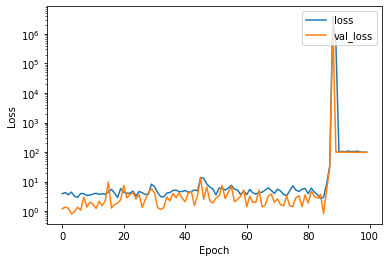

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.yscale("log")
plt.legend(loc='upper right')

test_loss = model_cnn.evaluate(data.TS_features, [data.TS_targets_pos, data.TS_targets_rot], verbose=2)


print result full dataset

In [7]:
data = DAO("datasetaitoff_path720.csv")
data.read()

data.features=tf.reshape(data.features,[-1,720,1,1])
data.targets=tf.reshape(data.targets,[-1,3])

data.TS_targets_pos=tf.gather(data.targets,[0,1],axis=1)
data.TS_targets_rot=tf.gather(data.targets,[2],axis=1)

In [8]:
model_cnn = model_define(data.features)

model_cnn.compile(optimizer = "adam",
    loss=loss_fn
    )

model_cnn.load_weights("models/Basis_cp-epoch-train.ckpt")

In [16]:
pos_array = []
rot_array = []

for index in range(data.features.shape[0]):

    test = data.features[index]

    test = tf.reshape(test,[-1,720,1,1])

    model_result = model_cnn.predict(test)

    pos_array.append(model_result[0][0])
    rot_array.append(model_result[1][0][0])


In [15]:
test = data.features[0]

test = tf.reshape(test,[-1,720,1,1])

model_cnn.predict(test)[1][0][0]


1.8054168

In [22]:
data.targets[0].numpy()

array([7.55     , 8.55     , 0.3577925])

In [19]:
with open('metrics/Basis_estimate.csv', 'w') as f:
    for i in range(len(pos_array)):
        f.write("{};{};{};{}\n".format(i,pos_array[i][0],pos_array[i][1],rot_array[i]))

In [ ]:
with open('metrics/Ground_truth.csv', 'w') as f:
    for i in range(data.targets.shape[0]):
        f.write("{};{};{};{}\n".format(i,data.targets[i][0].numpy(),data.targets[i][1].numpy(),data.targets[i][2].numpy()))

#save/load model weights

In [ ]:
checkpoint_path="models/cp-{epoch}.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)


In [10]:
#save Model weights
model_cnn.save("models/cp-epoch15-23M.ckpt")

2022-03-16 17:27:21.360906: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/cp-epoch15-23M.ckpt/assets


In [ ]:
#load Model weights
model_cnn.load_weights("models/cp-epoch15-23M.ckpt")

#analysis test data

In [43]:
result = model_cnn.predict(data.TS_features)

In [44]:
pos_test = result[:,0:2]
rot_test = result[:,2]

In [ ]:
#reformat data

data.read()
data.divide_data(0.25)

In [47]:
pos_real = np.array([data.TS_targets["pos_x"].to_list(),data.TS_targets["pos_y"].to_list()]).T
rot_real = (data.TS_targets["pos_yaw"]).to_numpy()

In [48]:
pos_mse, rot_mse = 0,0

for i in range(len(pos_real)):
    pos_mse += (np.sqrt(((pos_real[i,0]-pos_test[i,0])**2)+((pos_real[i,1]-pos_test[i,1])**2)))/len(pos_test)

for i in range(len(rot_real)):
    rot_mse += np.sqrt((rot_real[i]-rot_test[0])**2)/len(rot_real)
